In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
import time
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
from PIL import Image
from datetime import datetime
import matplotlib.pyplot as plt
import os

In [2]:
from transformers import GPT2Tokenizer, GPT2Model,GPT2LMHeadModel,AutoModelForCausalLM
from transformers import CLIPProcessor, CLIPVisionModelWithProjection

model_file_name = "openai-community/gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_file_name,return_tensors='pt',pad_token="<|endoftext|>")# we must add pad token
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

In [5]:
d_model = 768
device = "cuda"

In [6]:
import torch.nn.functional as F
from torch.nn import TransformerDecoder, TransformerDecoderLayer
from torch.utils.data import dataset
import math
class Net(nn.Module):
    def __init__(self,d_model,vocab_size):
        super(Net,self).__init__()

        self.d_model = d_model
        self.vocab_size = vocab_size

        self.image_encoder = CLIPVisionModelWithProjection.from_pretrained("openai/clip-vit-base-patch32")

        self.image_out = nn.Sequential(
            nn.Linear(512, self.d_model), nn.ReLU(), nn.Linear(self.d_model, self.d_model)
        )

        self.text_decoder = GPT2LMHeadModel.from_pretrained(model_file_name,add_cross_attention=True)
        self.text_decoder.resize_token_embeddings(self.vocab_size)

    def forward(self, image,text,attention_mask):

        batch_size = image.size(0)

        image_vec = self.image_encoder(image).image_embeds

        image_vec = self.image_out(image_vec.view(batch_size,512))
        image_vec = image_vec.unsqueeze(1)

        output = self.text_decoder(text,attention_mask=attention_mask,encoder_hidden_states=image_vec)[0]#.last_hidden_state

        return output
model = Net(d_model,tokenizer.vocab_size)

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at openai-community/gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.1.crossattention.q_attn.weight', 'h.1.ln_cross_attn.bias', 'h.1.ln_cross_attn.weight', 'h.10.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.weight', 'h.10.crossattention.c_proj.bias', 'h.10.crossattention.c_proj.weight', 'h.10.crossattention.q_attn.bias', 'h.10.crossattention.q_attn.weight', 'h.10.ln_cross_attn.bias', 'h.10.ln_cross_attn.weight', 'h.11.crossattention.c_attn.bias', 'h.11.crossattention.c_attn.weigh

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [7]:
model.load_state_dict(torch.load("gpt_caption_clip.pt"))

<All keys matched successfully>

In [8]:
model.to(device)

Net(
  (image_encoder): CLIPVisionModelWithProjection(
    (vision_model): CLIPVisionTransformer(
      (embeddings): CLIPVisionEmbeddings(
        (patch_embedding): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
        (position_embedding): Embedding(50, 768)
      )
      (pre_layrnorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (encoder): CLIPEncoder(
        (layers): ModuleList(
          (0-11): 12 x CLIPEncoderLayer(
            (self_attn): CLIPAttention(
              (k_proj): Linear(in_features=768, out_features=768, bias=True)
              (v_proj): Linear(in_features=768, out_features=768, bias=True)
              (q_proj): Linear(in_features=768, out_features=768, bias=True)
              (out_proj): Linear(in_features=768, out_features=768, bias=True)
            )
            (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (mlp): CLIPMLP(
              (activation_fn): QuickGELUActivation()
       

In [9]:
def greedy_predict(img_path,model):
  img = Image.open(img_path)
  img = processor(text=None,images=img,return_tensors="pt")["pixel_values"]

  model.eval()

  img = img.to(device)
  attention_mask = torch.zeros(1,1).to(device)
  text = torch.Tensor([tokenizer.eos_token_id]).unsqueeze(0).to(device)

  out = model(img,text.long(),attention_mask)

  _, indices = torch.max(out,2)

  text = torch.cat((text,indices),1)
  attention_mask = torch.cat((attention_mask,torch.zeros(1,1).to(device)),1)
  attention_mask[:,0]=1
  i = 1

  while text[:,-1]!= tokenizer.eos_token_id and i<100:

    attention_mask[:,i] = 1

    out = model(img,text.long(),attention_mask)
    _, indices = torch.max(out[:,i,:],1)

    text = torch.cat((text,indices.unsqueeze(0)),1)
    attention_mask = torch.cat((attention_mask,torch.zeros(1,1).to(device)),1)
    i+=1

  return tokenizer.decode(text[0])



In [3]:
!wget "https://th.bing.com/th/id/R.cfcea7bab839544cbd50bad837242ed3?rik=i38TTljz3p%2foig&pid=ImgRaw&r=0" -O "dog.jpg"

--2024-07-06 11:14:05--  https://th.bing.com/th/id/R.cfcea7bab839544cbd50bad837242ed3?rik=i38TTljz3p%2foig&pid=ImgRaw&r=0
Resolving th.bing.com (th.bing.com)... 23.32.29.96, 125.56.219.18, 23.32.29.91, ...
Connecting to th.bing.com (th.bing.com)|23.32.29.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 442220 (432K) [image/jpeg]
Saving to: ‘dog.jpg’

dog.jpg             100%[===================>] 431.86K  --.-KB/s    in 0.005s  

2024-07-06 11:14:05 (89.4 MB/s) - ‘dog.jpg’ saved [442220/442220]



In [10]:
predicted_caption = greedy_predict("dog.jpg",model)

<|endoftext|>A black and white dog with a white collar.<|endoftext|>


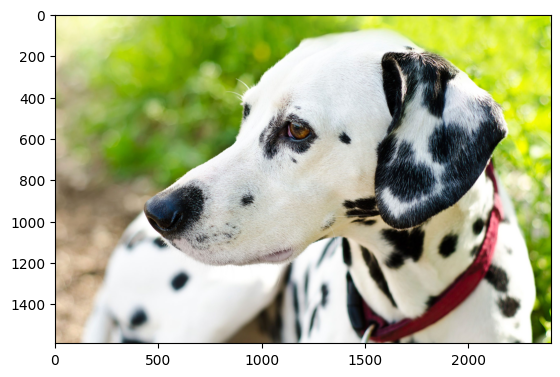

In [11]:
plt.imshow(Image.open("dog.jpg"))
print(predicted_caption)

In [12]:
!wget "https://th.bing.com/th/id/R.4d08ecdbf9bfa9577f27f95502d1c00e?rik=j%2bcHdo%2bXcwrutg&riu=http%3a%2f%2fimages6.fanpop.com%2fimage%2fphotos%2f39000000%2fCat-cats-39082303-1680-1050.jpg&ehk=f%2b5N40ilqclfL57U68rNJy5XtluuL%2b8UtQl3TkAEPfs%3d&risl=&pid=ImgRaw&r=0" -O "cat.jpg"

--2024-07-06 11:19:21--  https://th.bing.com/th/id/R.4d08ecdbf9bfa9577f27f95502d1c00e?rik=j%2bcHdo%2bXcwrutg&riu=http%3a%2f%2fimages6.fanpop.com%2fimage%2fphotos%2f39000000%2fCat-cats-39082303-1680-1050.jpg&ehk=f%2b5N40ilqclfL57U68rNJy5XtluuL%2b8UtQl3TkAEPfs%3d&risl=&pid=ImgRaw&r=0
Resolving th.bing.com (th.bing.com)... 23.32.29.91, 23.32.29.99, 125.56.219.18, ...
Connecting to th.bing.com (th.bing.com)|23.32.29.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 683600 (668K) [image/jpeg]
Saving to: ‘cat.jpg’

cat.jpg             100%[===================>] 667.58K  --.-KB/s    in 0.04s   

2024-07-06 11:19:22 (16.4 MB/s) - ‘cat.jpg’ saved [683600/683600]



In [14]:
predicted_caption = greedy_predict("cat.jpg",model)

<|endoftext|>A brown dog is looking at the camera.<|endoftext|>


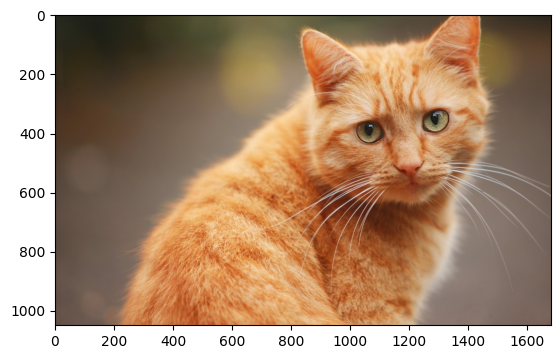

In [15]:
plt.imshow(Image.open("cat.jpg"))
print(predicted_caption)

In [16]:
!wget "https://th.bing.com/th/id/OIP.IgzUUSNL2BUvTprN60PEPQHaFe?rs=1&pid=ImgDetMain" -O "skateboarder.jpg"

--2024-07-06 11:19:51--  https://th.bing.com/th/id/OIP.IgzUUSNL2BUvTprN60PEPQHaFe?rs=1&pid=ImgDetMain
Resolving th.bing.com (th.bing.com)... 23.32.29.96, 125.56.219.3, 23.32.29.107, ...
Connecting to th.bing.com (th.bing.com)|23.32.29.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11921 (12K) [image/jpeg]
Saving to: ‘skateboarder.jpg’

skateboarder.jpg    100%[===================>]  11.64K  --.-KB/s    in 0s      

2024-07-06 11:19:51 (126 MB/s) - ‘skateboarder.jpg’ saved [11921/11921]



In [17]:
predicted_caption = greedy_predict("skateboarder.jpg",model)

<|endoftext|>A man in a blue shirt and sunglasses is airborne.<|endoftext|>


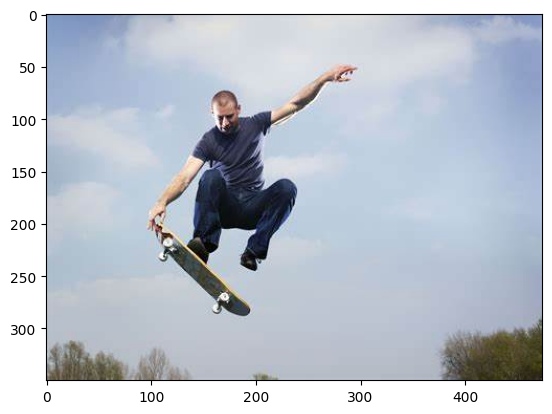

In [18]:
plt.imshow(Image.open("skateboarder.jpg"))
print(predicted_caption)

In [19]:
!wget "https://guernseypress.com/resizer/Rtuv7ibmC42JoY4az8kXlS9EUls=/1200x0/cloudfront-us-east-1.images.arcpublishing.com/mna/LMDFE54KHBCP5MZCBWTYGG6M5A.jpg" -O "skateboarder2.jpg"

--2024-07-06 11:22:04--  https://guernseypress.com/resizer/Rtuv7ibmC42JoY4az8kXlS9EUls=/1200x0/cloudfront-us-east-1.images.arcpublishing.com/mna/LMDFE54KHBCP5MZCBWTYGG6M5A.jpg
Resolving guernseypress.com (guernseypress.com)... 184.87.193.93, 184.87.193.84, 2600:1413:b000:13::b857:c184, ...
Connecting to guernseypress.com (guernseypress.com)|184.87.193.93|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81930 (80K) [image/jpeg]
Saving to: ‘skateboarder2.jpg’

skateboarder2.jpg   100%[===================>]  80.01K   305KB/s    in 0.3s    

2024-07-06 11:22:05 (305 KB/s) - ‘skateboarder2.jpg’ saved [81930/81930]



In [20]:
predicted_caption = greedy_predict("skateboarder2.jpg",model)

<|endoftext|>A woman in a white and blue outfit is skating.<|endoftext|>


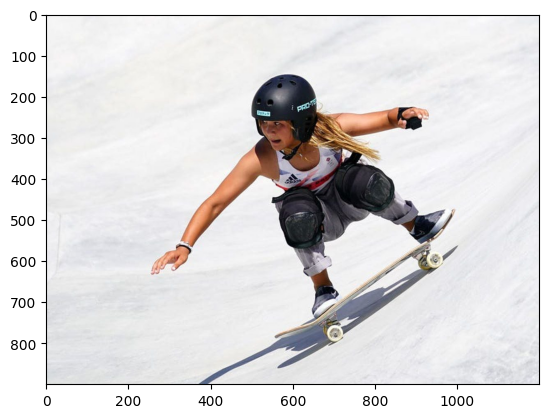

In [22]:
plt.imshow(Image.open("skateboarder2.jpg"))
print(predicted_caption)